**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2021*

----

# Trabajo práctico entregable - parte 2


En el ejercicio 1 de la parte 1 del entregable seleccionaron las filas y columnas relevantes al problema de predicción de precios de una propiedad. Además de ello, tuvieron que reducir el número de valores posibles para las variables categóricas utilizando información de dominio.

En el ejercicio 2 de la parte 1 del entregable imputaron los valores faltantes de las columnas `Suburb` y las columnas obtenidas a partir del conjunto de datos `airbnb`.

En esta notebook, **se utilizará resultado de dichas operaciones.**


In [312]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('talk')
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

In [313]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [314]:
import os
os.chdir('/content/drive/My Drive/Entregable2_Diplo')

In [6]:

melb_df_nuevo = pd.read_csv('/content/drive/My Drive/Entregable2_Diplo/melb_df_nuevo.csv')
melb_df_nuevo[:3]

,Suburb,Rooms,Type,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Regionname,precio_prom,city_uniq
0,Abbotsford,2,h,1480000.0,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,Northern Metropolitan,130.624031,NaN
1,Abbotsford,2,h,1035000.0,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,Northern Metropolitan,130.624031,NaN
2,Abbotsford,3,h,1465000.0,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,Northern Metropolitan,130.624031,NaN


## Ejercicio 1: Encoding

1. Seleccionar todas las filas y columnas del conjunto de datos obtenido en la parte 1 del entregable, **excepto** `BuildingArea` y `YearBuilt`, que volveremos a imputar más adelante.

2. Aplicar una codificación One-hot encoding a cada fila, tanto para variables numéricas como categóricas. Si lo consideran necesario, pueden volver a reducir el número de categorías únicas.

Algunas opciones:
  1. Utilizar `OneHotEncoder` junto con el parámetro `categories` para las variables categóricas y luego usar `numpy.hstack` para concatenar el resultado con las variables numéricas. 
  2. `DictVectorizer` con algunos pasos de pre-proceso previo.

Recordar también que el atributo `pandas.DataFrame.values` permite acceder a la matriz de numpy subyacente a un DataFrame.


Variables categóricas para codificación onehotencoder

In [8]:
categorical_cols = ['Suburb','Type', 'CouncilArea', 'Regionname']

In [15]:
melb_df_nuevo[categorical_cols].nunique()

Suburb         311
Type             3
CouncilArea    160
Regionname       6
dtype: int64

In [16]:
melb_df_nuevo[categorical_cols].isna().sum()

Suburb         0
Type           0
CouncilArea    0
Regionname     0
dtype: int64

One-hot encoding

In [18]:
OH_encode = OneHotEncoder(sparse=False)
OH_encode.fit(melb_df_nuevo[categorical_cols])
categorical_ohencoded = OH_encode.transform(melb_df_nuevo[categorical_cols])
cat_ohencod_df = pd.DataFrame(data=categorical_ohencoded, columns=OH_encode.get_feature_names(categorical_cols))
cat_ohencod_df

,Suburb_Abbotsford,Suburb_Aberfeldie,Suburb_Airport West,Suburb_Albanvale,Suburb_Albert Park,Suburb_Albion,Suburb_Alphington,Suburb_Altona,Suburb_Altona Meadows,Suburb_Altona North,Suburb_Ardeer,Suburb_Armadale,Suburb_Ascot Vale,Suburb_Ashburton,Suburb_Ashwood,Suburb_Aspendale,Suburb_Aspendale Gardens,Suburb_Attwood,Suburb_Avondale Heights,Suburb_Balaclava,Suburb_Balwyn,Suburb_Balwyn North,Suburb_Bayswater,Suburb_Bayswater North,Suburb_Beaconsfield,Suburb_Beaconsfield Upper,Suburb_Beaumaris,Suburb_Bellfield,Suburb_Bentleigh,Suburb_Bentleigh East,Suburb_Berwick,Suburb_Black Rock,Suburb_Blackburn,Suburb_Blackburn North,Suburb_Blackburn South,Suburb_Bonbeach,Suburb_Boronia,Suburb_Box Hill,Suburb_Braybrook,Suburb_Briar Hill,...,CouncilArea_Point Cook,CouncilArea_Port Melbourne,CouncilArea_Port Phillip,CouncilArea_Prahran,CouncilArea_Princes Hill,CouncilArea_Reservoir,CouncilArea_Richmond,CouncilArea_Ringwood,CouncilArea_Ringwood North,CouncilArea_Roxburgh Park,CouncilArea_South Melbourne,CouncilArea_South Yarra,CouncilArea_Springvale,CouncilArea_Springvale South,CouncilArea_St Helena,CouncilArea_St Kilda,CouncilArea_Stonnington,CouncilArea_Surrey Hills,CouncilArea_Toorak,CouncilArea_Tullamarine,CouncilArea_Vermont,CouncilArea_Vermont South,CouncilArea_Wallan,CouncilArea_Warrandyte,CouncilArea_Werribee,CouncilArea_West Footscray,CouncilArea_Wheelers Hill,CouncilArea_Whitehorse,CouncilArea_Whittlesea,CouncilArea_Windsor,CouncilArea_Wyndham,CouncilArea_Yallambie,CouncilArea_Yarra,CouncilArea_Yarra Ranges,Regionname_Eastern Metropolitan,Regionname_Northern Metropolitan,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Victoria,Regionname_Western Metropolitan
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1

## Ejercicio 2: Imputación por KNN

En el teórico se presentó el método `IterativeImputer` para imputar valores faltantes en variables numéricas. Sin embargo, los ejemplos presentados sólo utilizaban algunas variables numéricas presentes en el conjunto de datos. En este ejercicio, utilizaremos la matriz de datos codificada para imputar datos faltantes de manera más precisa.

1. Agregue a la matriz obtenida en el punto anterior las columnas `YearBuilt` y `BuildingArea`.
2. Aplique una instancia de `IterativeImputer` con un estimador `KNeighborsRegressor` para imputar los valores de las variables. ¿Es necesario estandarizar o escalar los datos previamente?
3. Realice un gráfico mostrando la distribución de cada variable antes de ser imputada, y con ambos métodos de imputación.

Variables numéricas menos BuildingArea y YearBuilt

In [79]:
numerical_cols = ['Rooms', 'Distance','Bedroom2', 'Bathroom', 'Car', 'Landsize','precio_prom']

In [80]:
melb_df_nuevo_numeric = pd.concat([melb_df_nuevo[numerical_cols], melb_df_nuevo[['YearBuilt', 'BuildingArea']]], axis=1)
melb_df_nuevo_numeric 

,Rooms,Distance,Bedroom2,Bathroom,Car,Landsize,precio_prom,YearBuilt,BuildingArea
0,2,2.5,2.0,1.0,1.0,202.0,130.624031,NaN,NaN
1,2,2.5,2.0,1.0,0.0,156.0,130.624031,1900.0,79.0
2,3,2.5,3.0,2.0,0.0,134.0,130.624031,1900.0,150.0
3,3,2.5,3.0,2.0,1.0,94.0,130.624031,NaN,NaN
4,4,2.5,3.0,1.0,2.0,120.0,130.624031,2014.0,142.0
...,...,...,...,...,...,...,...,...,...
13385,4,16.7,4.0,2.0,2.0,652.0,124.026455,1981.0,NaN
13386,3,6.8,3.0,2.0,2.0,333.0,191.094595,1995.0,133.0
13387,3,6.8,3.0,2.0,4.0,436.0,191.094595,1997.0,NaN
13388,4,6.8,4.0,1.0,5.0,866.0,191.094595,1920.0,157.0


In [147]:
melb_df_nuevo_numeric.describe() 

,Rooms,Distance,Bedroom2,Bathroom,Car,Landsize,precio_prom,YearBuilt,BuildingArea
count,13390.000000,13390.000000,13390.000000,13390.000000,13390.000000,13390.000000,13378.000000,8102.000000,7040.000000
mean,2.935176,10.148125,2.912323,1.533682,1.602614,555.209111,131.120338,1965.265984,152.178722
std,0.949534,5.800355,0.939068,0.674333,0.925345,4002.041235,64.386741,35.786402,544.295339
min,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,40.000000,1880.000000,1.000000
25%,2.000000,6.200000,2.000000,1.000000,1.000000,178.000000,94.672646,1941.000000,93.000000
50%,3.000000,9.200000,3.000000,1.000000,2.000000,442.000000,114.612500,1970.000000,126.000000
75%,3.000000,13.000000,3.000000,2.000000,2.000000,650.000000,147.729515,1999.000000,174.000000
max,8.000000,48.100000,7.000000,5.000000,6.000000,433014.000000,759.083333,2018.000000,44515.000000


Para utilizar IterativeImputer con un estimador KNeighborsRegressor es necesario escalar los datos, dado que KNN utiliza como distancia entre valores la distancia euclidia, la cual necesita que los valores se encuentren en rangos equivalentes.

In [218]:
pwer_scaler = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True, copy=True).fit(melb_df_nuevo_numeric)
melb_df_nuevo_numeric_trans = pwer_scaler.transform(melb_df_nuevo_numeric)
melb_df_nuevo_numeric_trans

array([[-0.98375889, -1.84966885, -0.9688033 , ...,  0.29834909,
                nan,         nan],
       [-0.98375889, -1.84966885, -0.9688033 , ...,  0.29834909,
        -1.6310748 , -0.78384914],
       [ 0.11374446, -1.84966885,  0.13720036, ...,  0.29834909,
        -1.6310748 ,  0.27987366],
       ...,
       [ 0.11374446, -0.4883037 ,  0.13720036, ...,  1.21163021,
         0.90002138,         nan],
       [ 1.11148165, -0.4883037 ,  1.14502483, ...,  1.21163021,
        -1.24407663,  0.35999542],
       [ 1.11148165, -0.6098369 ,  1.14502483, ...,  0.39613165,
        -1.24407663, -0.2190708 ]])

In [219]:
melb_df_nuevo_numeric_trans = pd.DataFrame(melb_df_nuevo_numeric_trans, columns=['Rooms', 'Distance','Bedroom2', 'Bathroom', 'Car', 'Landsize','precio_prom','YearBuilt','BuildingArea'])

In [220]:
melb_df_nuevo_numeric_trans

,Rooms,Distance,Bedroom2,Bathroom,Car,Landsize,precio_prom,YearBuilt,BuildingArea
0,-0.983759,-1.849669,-0.968803,-0.88208,-0.601157,-0.285100,0.298349,NaN,NaN
1,-0.983759,-1.849669,-0.968803,-0.88208,-2.195844,-0.439765,0.298349,-1.631075,-0.783849
2,0.113744,-1.849669,0.137200,0.98850,-2.195844,-0.525156,0.298349,-1.631075,0.279874
3,0.113744,-1.849669,0.137200,0.98850,-0.601157,-0.709366,0.298349,NaN,NaN
4,1.111482,-1.849669,0.137200,-0.88208,0.528535,-0.584674,0.298349,1.553599,0.184397
...,...,...,...,...,...,...,...,...,...
13385,1.111482,1.165189,1.145025,0.98850,0.528535,0.592687,0.160023,0.352457,NaN
13386,0.113744,-0.488304,0.137200,0.98850,0.528535,0.051292,1.211630,0.828141,0.071474
13387,0.113744,-0.488304,0.137200,0.98850,2.201324,0.255195,1.211630,0.900021,NaN
13388,1.111482,-0.488304,1.145025,-0.88208,2.874936,0.856940,1.211630,-1.244077,0.359995


In [221]:
melb_df_nuevo_numeric_trans.describe()

,Rooms,Distance,Bedroom2,Bathroom,Car,Landsize,precio_prom,YearBuilt,BuildingArea
count,1.339000e+04,1.339000e+04,1.339000e+04,1.339000e+04,1.339000e+04,1.339000e+04,1.337800e+04,8.102000e+03,7.040000e+03
mean,1.032970e-14,2.527519e-15,-1.861593e-16,3.544920e-16,1.526923e-14,-1.058358e-15,-1.100733e-15,-1.361373e-15,1.126703e-16
std,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000062e+00,1.000071e+00
min,-2.231607e+00,-3.563949e+00,-2.222345e+00,-8.820805e-01,-2.195844e+00,-1.933870e+00,-3.925722e+00,-1.964778e+00,-5.206237e+00
25%,-9.837589e-01,-6.349262e-01,-9.688033e-01,-8.820805e-01,-6.011574e-01,-3.623417e-01,-6.210311e-01,-7.717998e-01,-5.240320e-01
50%,1.137445e-01,2.167332e-02,1.372004e-01,-8.820805e-01,5.285355e-01,2.659903e-01,-5.759753e-02,1.051112e-02,-2.084219e-02
75%,1.137445e-01,6.622652e-01,1.372004e-01,9.885000e-01,5.285355e-01,5.899506e-01,6.128798e-01,9.729227e-01,5.428409e-01
max,4.511938e+00,3.669669e+00,3.795905e+00,2.016681e+00,3.479135e+00,1.882436e+01,3.381427e+00,1.719027e+00,1.667853e+01


IterativeImputer con estimador KNeighborsRegressor

In [222]:
melb_data_mice = melb_df_nuevo_numeric_trans.copy(deep=True)
mice_imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor())
melb_data_mice[['YearBuilt','BuildingArea', 'precio_prom']] = mice_imputer.fit_transform(
    melb_data_mice[['YearBuilt', 'BuildingArea', 'precio_prom']])

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [223]:
melb_data_mice

,Rooms,Distance,Bedroom2,Bathroom,Car,Landsize,precio_prom,YearBuilt,BuildingArea
0,-0.983759,-1.849669,-0.968803,-0.88208,-0.601157,-0.285100,0.298349,-0.078413,0.728546
1,-0.983759,-1.849669,-0.968803,-0.88208,-2.195844,-0.439765,0.298349,-1.631075,-0.783849
2,0.113744,-1.849669,0.137200,0.98850,-2.195844,-0.525156,0.298349,-1.631075,0.279874
3,0.113744,-1.849669,0.137200,0.98850,-0.601157,-0.709366,0.298349,-0.078413,0.728546
4,1.111482,-1.849669,0.137200,-0.88208,0.528535,-0.584674,0.298349,1.553599,0.184397
...,...,...,...,...,...,...,...,...,...
13385,1.111482,1.165189,1.145025,0.98850,0.528535,0.592687,0.160023,0.352457,0.275246
13386,0.113744,-0.488304,0.137200,0.98850,0.528535,0.051292,1.211630,0.828141,0.071474
13387,0.113744,-0.488304,0.137200,0.98850,2.201324,0.255195,1.211630,0.900021,1.262226
13388,1.111482,-0.488304,1.145025,-0.88208,2.874936,0.856940,1.211630,-1.244077,0.359995


In [224]:
mice_year_built2 = melb_data_mice.YearBuilt.to_frame()
mice_year_built2['Imputation'] = 'KNN over YearBuilt'
melb_year_built23 = melb_df_nuevo_numeric_trans.YearBuilt.dropna().to_frame()
melb_year_built23['Imputation'] = 'Original'

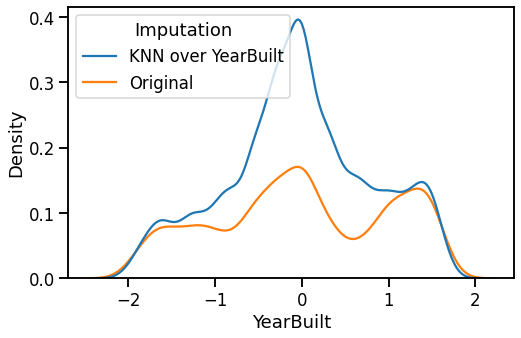

In [225]:
data = pd.concat([mice_year_built2, melb_year_built23])
fig = plt.figure(figsize=(8, 5))
g = sns.kdeplot(data=data, x='YearBuilt', hue='Imputation')

In [226]:
mice_year_build2 = melb_data_mice.BuildingArea.to_frame()
mice_year_build2['Imputation'] = 'KNN over BuildingArea'
melb_year_build23 = melb_df_nuevo_numeric_trans.BuildingArea.dropna().to_frame()
melb_year_build23['Imputation'] = 'Original'

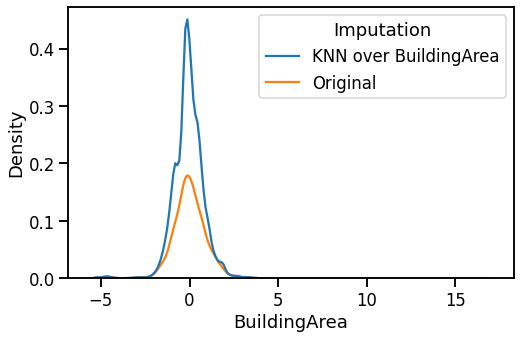

In [227]:
data2 = pd.concat([mice_year_build2, melb_year_build23])
fig = plt.figure(figsize=(8, 5))
g = sns.kdeplot(data=data2, x='BuildingArea', hue='Imputation')

In [217]:
melb_data_mice.isna().sum()

Rooms           0
Distance        0
Bedroom2        0
Bathroom        0
Car             0
Landsize        0
precio_prom     0
YearBuilt       0
BuildingArea    0
dtype: int64

In [292]:
df_melb_final = pd.concat([cat_ohencod_df,melb_data_mice], axis=1)
df_melb_final

,Suburb_Abbotsford,Suburb_Aberfeldie,Suburb_Airport West,Suburb_Albanvale,Suburb_Albert Park,Suburb_Albion,Suburb_Alphington,Suburb_Altona,Suburb_Altona Meadows,Suburb_Altona North,Suburb_Ardeer,Suburb_Armadale,Suburb_Ascot Vale,Suburb_Ashburton,Suburb_Ashwood,Suburb_Aspendale,Suburb_Aspendale Gardens,Suburb_Attwood,Suburb_Avondale Heights,Suburb_Balaclava,Suburb_Balwyn,Suburb_Balwyn North,Suburb_Bayswater,Suburb_Bayswater North,Suburb_Beaconsfield,Suburb_Beaconsfield Upper,Suburb_Beaumaris,Suburb_Bellfield,Suburb_Bentleigh,Suburb_Bentleigh East,Suburb_Berwick,Suburb_Black Rock,Suburb_Blackburn,Suburb_Blackburn North,Suburb_Blackburn South,Suburb_Bonbeach,Suburb_Boronia,Suburb_Box Hill,Suburb_Braybrook,Suburb_Briar Hill,...,CouncilArea_Roxburgh Park,CouncilArea_South Melbourne,CouncilArea_South Yarra,CouncilArea_Springvale,CouncilArea_Springvale South,CouncilArea_St Helena,CouncilArea_St Kilda,CouncilArea_Stonnington,CouncilArea_Surrey Hills,CouncilArea_Toorak,CouncilArea_Tullamarine,CouncilArea_Vermont,CouncilArea_Vermont South,CouncilArea_Wallan,CouncilArea_Warrandyte,CouncilArea_Werribee,CouncilArea_West Footscray,CouncilArea_Wheelers Hill,CouncilArea_Whitehorse,CouncilArea_Whittlesea,CouncilArea_Windsor,CouncilArea_Wyndham,CouncilArea_Yallambie,CouncilArea_Yarra,CouncilArea_Yarra Ranges,Regionname_Eastern Metropolitan,Regionname_Northern Metropolitan,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Victoria,Regionname_Western Metropolitan,Rooms,Distance,Bedroom2,Bathroom,Car,Landsize,precio_prom,YearBuilt,BuildingArea
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.983759,-1.849669,-0.968803,-0.88208,-0.601157,-0.285100,0.298349,-0.078413,0.728546
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.983759,-1.849669,-0.968803,-0.88208,-2.195844,-0.439765,0.298349,-1.631075,-0.783849
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.113744,-1.849669,0.137200,0.98850,-2.195844,-0.525156,0.298349,-1.631075,0.279874
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.113744,-1.849669,0.137200,0.98850,-0.601157,-0.709366,0.298349,-0.078413,0.728546
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.111482,-1.849669,0.137200,-0.88208,0.528535,-0.584674,0.298349,1.553599,0.184397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

## Ejercicio 3: Reducción de dimensionalidad.

Utilizando la matriz obtenida en el ejercicio anterior:
1. Aplique `PCA` para obtener $n$ componentes principales de la matriz, donde `n = min(20, X.shape[0])`. ¿Es necesario estandarizar o escalar los datos?
2. Grafique la varianza capturada por los primeros $n$ componentes principales, para cada $n$.
3. En base al gráfico, seleccione las primeras $m$ columnas de la matriz transformada para agregar como nuevas características al conjunto de datos.

Es necesario estandarizar los datos para realizar PCA, los mismos ya fueron estandarizados previamente

In [281]:
df_melb_final.shape

(13390, 489)

In [301]:
pca_imp = PCA(n_components=100)
pca_melb = pca_imp.fit_transform(df_melb_final)


In [302]:
variance=np.cumsum(np.round(pca_imp.explained_variance_ratio_, decimals=5)*100)
variance

array([30.891, 42.475, 50.958, 57.897, 63.377, 68.23 , 72.373, 76.006,
       78.608, 81.039, 82.444, 83.666, 84.552, 85.299, 86.016, 86.642,
       87.21 , 87.744, 88.234, 88.661, 89.08 , 89.465, 89.817, 90.139,
       90.443, 90.739, 90.976, 91.204, 91.368, 91.527, 91.676, 91.819,
       91.955, 92.09 , 92.223, 92.351, 92.476, 92.598, 92.715, 92.83 ,
       92.942, 93.053, 93.162, 93.269, 93.374, 93.476, 93.574, 93.672,
       93.766, 93.86 , 93.952, 94.043, 94.131, 94.218, 94.302, 94.383,
       94.463, 94.542, 94.62 , 94.697, 94.773, 94.846, 94.916, 94.986,
       95.055, 95.124, 95.192, 95.259, 95.325, 95.39 , 95.455, 95.519,
       95.582, 95.642, 95.702, 95.762, 95.82 , 95.877, 95.933, 95.987,
       96.04 , 96.092, 96.143, 96.192, 96.241, 96.29 , 96.337, 96.384,
       96.429, 96.473, 96.517, 96.561, 96.604, 96.646, 96.688, 96.729,
       96.77 , 96.81 , 96.849, 96.888])

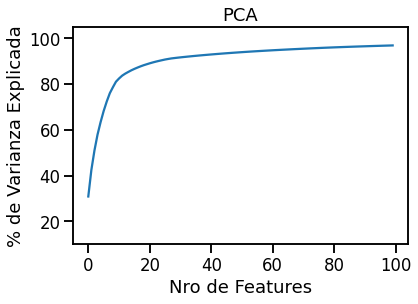

In [303]:
plt.ylabel('% de Varianza Explicada')
plt.xlabel('Nro de Features')
plt.title('PCA')
plt.ylim(10,105)

plt.plot(variance)

Con los primeros 21 PCAs recuperamos aproximadamente el 90% de la variancia contenida en los datos

In [307]:
melb_df_pca = pd.DataFrame(data=pca_melb[:,:21])
melb_df_pca

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,-1.876959,-0.631684,0.797221,-0.299222,0.515073,0.893896,1.429885,-0.441680,0.243459,-0.032485,-0.433381,0.358939,0.015822,-0.085990,0.078154,-0.019260,0.591501,0.414697,0.014443,0.006302,0.016931
1,-2.877063,-0.831900,2.214853,-0.983118,-0.126198,0.272163,-0.085811,0.163576,0.612129,0.170673,-0.275985,0.155954,0.065458,0.001449,0.170086,0.026543,0.568391,0.384580,-0.020981,0.032874,0.054672
2,-0.927254,-1.973219,1.751459,-2.051620,-0.473704,0.311960,0.271969,0.648664,0.760660,0.210252,-0.041713,0.067654,-0.071974,-0.033657,0.158406,-0.045784,0.547664,0.350987,-0.029348,0.052897,0.046866
3,-0.318505,-1.688522,0.166045,-1.511206,0.388087,0.718345,0.846937,-0.048038,0.526319,0.095674,-0.324020,0.254265,-0.141765,-0.092514,0.104612,-0.048876,0.568041,0.368449,0.002856,0.022572,0.023247
4,-0.179607,-0.778513,-0.422542,-0.710043,1.143205,0.806605,0.531812,-2.252802,-0.193729,-0.376378,-0.496951,0.377082,-0.093683,-0.145060,0.097761,-0.014159,0.587073,0.408822,0.039710,-0.060505,0.001541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13385,2.302935,-0.048673,-0.428197,0.166639,-0.545355,-0.188186,-0.353590,-0.135191,0.356191,0.156988,-0.027079,-0.075674,-0.185417,-0.019679,-0.096231,-0.074612,0.152720,0.381539,0.141109,-0.179183,-0.528865
13386,0.515319,-1.163442,-0.939845,0.305010,0.080824,0.667543,-0.026538,-0.322535,-0.151150,1.197112,-0.441453,-0.027918,-0.099683,-0.061424,-0.200766,-0.253615,0.091625,-0.125632,-0.063152,0.798571,-0.107276
13387,1.432846,-1.179948,-1.402279,1.122503,1.123385,0.674549,1.149898,-0.234333,-0.283494,1.125549,-0.320400,0.061943,-0.071175,-0.117240,-0.227416,-0.292377,0.118177,-0.086825,-0.028653,0.792398,-0.130596
13388,1.870612,-1.027520,0.911978,1.907114,2.260459,-0.679842,0.134225,-0.954664,-0.571445,0.835988,0.414627,-0.164681,0.168738,-0.115960,-0.082645,-0.261070,0.149486,0.006363,-0.003026,0.785797,-0.122503


In [309]:
df_melb_pca_final = pd.concat([df_melb_final,melb_df_pca], axis=1)
df_melb_pca_final

,Suburb_Abbotsford,Suburb_Aberfeldie,Suburb_Airport West,Suburb_Albanvale,Suburb_Albert Park,Suburb_Albion,Suburb_Alphington,Suburb_Altona,Suburb_Altona Meadows,Suburb_Altona North,Suburb_Ardeer,Suburb_Armadale,Suburb_Ascot Vale,Suburb_Ashburton,Suburb_Ashwood,Suburb_Aspendale,Suburb_Aspendale Gardens,Suburb_Attwood,Suburb_Avondale Heights,Suburb_Balaclava,Suburb_Balwyn,Suburb_Balwyn North,Suburb_Bayswater,Suburb_Bayswater North,Suburb_Beaconsfield,Suburb_Beaconsfield Upper,Suburb_Beaumaris,Suburb_Bellfield,Suburb_Bentleigh,Suburb_Bentleigh East,Suburb_Berwick,Suburb_Black Rock,Suburb_Blackburn,Suburb_Blackburn North,Suburb_Blackburn South,Suburb_Bonbeach,Suburb_Boronia,Suburb_Box Hill,Suburb_Braybrook,Suburb_Briar Hill,...,CouncilArea_Wyndham,CouncilArea_Yallambie,CouncilArea_Yarra,CouncilArea_Yarra Ranges,Regionname_Eastern Metropolitan,Regionname_Northern Metropolitan,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Victoria,Regionname_Western Metropolitan,Rooms,Distance,Bedroom2,Bathroom,Car,Landsize,precio_prom,YearBuilt,BuildingArea,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.983759,-1.849669,-0.968803,-0.88208,-0.601157,-0.285100,0.298349,-0.078413,0.728546,-1.876959,-0.631684,0.797221,-0.299222,0.515073,0.893896,1.429885,-0.441680,0.243459,-0.032485,-0.433381,0.358939,0.015822,-0.085990,0.078154,-0.019260,0.591501,0.414697,0.014443,0.006302,0.016931
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.983759,-1.849669,-0.968803,-0.88208,-2.195844,-0.439765,0.298349,-1.631075,-0.783849,-2.877063,-0.831900,2.214853,-0.983118,-0.126198,0.272163,-0.085811,0.163576,0.612129,0.170673,-0.275985,0.155954,0.065458,0.001449,0.170086,0.026543,0.568391,0.384580,-0.020981,0.032874,0.054672
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.113744,-1.849669,0.137200,0.98850,-2.195844,-0.525156,0.298349,-1.631075,0.279874,-0.927254,-1.973219,1.751459,-2.051620,-0.473704,0.311960,0.271969,0.648664,0.760660,0.210252,-0.041713,0.067654,-0.071974,-0.033657,0.158406,-0.045784,0.547664,0.350987,-0.029348,0.052897,0.046866
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.113744,-1.849669,0.137200,0.98850,-0.601157,-0.709366,0.298349,-0.078413,0.728546,-0.318505,-1.688522,0.166045,-1.511206,0.388087,0.718345,0.846937,-0.048038,0.526319,0.095674,-0.324020,0.254265,-0.141765,-0.092514,0.104612,-0.048876,0.568041,0.368449,0.002856,0.022572,0.023247
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.111482,-1.849669,0.137200,-0.88208,0.528535,-0.584674,0.298349,1.553599,0.184397,-0.179607,-0.778513,-0.422542,-0.710043,1.143205,0.806605,0.531812,-2.252802,-0.193729,-0.376378,-0.496951,0.377082,-0.093683,-0.145060,0.097761,-0.014159,0.587073,0.408822,0.039710,-0.060505,0.001541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [316]:
df_melb_pca_final.to_csv("df_melb_pca_final.csv")

## Ejercicio 4: Composición del resultado

Transformar nuevamente el conjunto de datos procesado en un `pandas.DataFrame` y guardarlo en un archivo.

Para eso, será necesario recordar el nombre original de cada columna de la matriz, en el orden correcto. Tener en cuenta:
1. El método `OneHotEncoder.get_feature_names` o el atributo `OneHotEncoder.categories_` permiten obtener una lista con los valores de la categoría que le corresponde a cada índice de la matriz.
2. Ninguno de los métodos aplicados intercambia de lugar las columnas o las filas de la matriz.

In [ ]:
## Small example
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

## If we process our data with the following steps:
categorical_cols = ['Type', 'Regionname']
numerical_cols = ['Rooms', 'Distance']
new_columns = []

# Step 1: encode categorical columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_cat = encoder.fit_transform(melb_df[categorical_cols])
for col, col_values in zip(categorical_cols, encoder.categories_):
  for col_value in col_values:
    new_columns.append('{}={}'.format(col, col_value))
print("Matrix has shape {}, with columns: {}".format(X_cat.shape, new_columns))

# Step 2: Append the numerical columns
import numpy
import pandas
X = numpy.hstack([X_cat, melb_df[numerical_cols].values])
new_columns.extend(numerical_cols)
print("Matrix has shape {}, with columns: {}".format(X_cat.shape, new_columns))

# Step 3: Append some new features, like PCA
pca = PCA(n_components=2)
pca_dummy_features = pca.fit_transform(X)
X_pca = numpy.hstack([X, pca_dummy_features])
new_columns.extend(['pca1', 'pca2'])

## Re-build dataframe
processed_melb_df = pandas.DataFrame(data=X_pca, columns=new_columns)
processed_melb_df.head()

Matrix has shape (13441, 9), with columns: ['Type=h', 'Type=t', 'Type=u', 'Regionname=Eastern Metropolitan', 'Regionname=Northern Metropolitan', 'Regionname=South-Eastern Metropolitan', 'Regionname=Southern Metropolitan', 'Regionname=Victoria', 'Regionname=Western Metropolitan']
Matrix has shape (13441, 9), with columns: ['Type=h', 'Type=t', 'Type=u', 'Regionname=Eastern Metropolitan', 'Regionname=Northern Metropolitan', 'Regionname=South-Eastern Metropolitan', 'Regionname=Southern Metropolitan', 'Regionname=Victoria', 'Regionname=Western Metropolitan', 'Rooms', 'Distance']


,Type=h,Type=t,Type=u,Regionname=Eastern Metropolitan,Regionname=Northern Metropolitan,Regionname=South-Eastern Metropolitan,Regionname=Southern Metropolitan,Regionname=Victoria,Regionname=Western Metropolitan,Rooms,Distance,pca1,pca2
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.5,-7.650841,-0.266237
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.5,-7.650841,-0.266237
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,2.5,-7.600617,0.640855
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,2.5,-7.600617,0.640855
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,2.5,-7.550392,1.547948


## Ejercicio 5: Documentación

En un documento `.pdf` o `.md` realizar un reporte de las operaciones que realizaron para obtener el conjunto de datos final. Se debe incluir:
  1. Criterios de exclusión (o inclusión) de filas
  2. Interpretación de las columnas presentes
  2. Todas las transofrmaciones realizadas

Este documento es de uso técnico exclusivamente, y su objetivo es permitir que otres desarrolladores puedan reproducir los mismos pasos y obtener el mismo resultado. Debe ser detallado pero consiso. Por ejemplo:

```
  ## Criterios de exclusión de ejemplos
  1. Se eliminan ejemplos donde el año de construcción es previo a 1900

  ## Características seleccionadas
  ### Características categóricas
  1. Type: tipo de propiedad. 3 valores posibles
  2. ...
  Todas las características categóricas fueron codificadas con un
  método OneHotEncoding utilizando como máximo sus 30 valores más 
  frecuentes.
  
  ### Características numéricas
  1. Rooms: Cantidad de habitaciones
  2. Distance: Distancia al centro de la ciudad.
  3. airbnb_mean_price: Se agrega el precio promedio diario de 
     publicaciones de la plataforma AirBnB en el mismo código 
     postal. [Link al repositorio con datos externos].

  ### Transformaciones:
  1. Todas las características numéricas fueron estandarizadas.
  2. La columna `Suburb` fue imputada utilizando el método ...
  3. Las columnas `YearBuilt` y ... fueron imputadas utilizando el 
     algoritmo ...
  4. ...

  ### Datos aumentados
  1. Se agregan las 5 primeras columnas obtenidas a través del
     método de PCA, aplicado sobre el conjunto de datos
     totalmente procesado.
```
